In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Tuple, Dict, Optional

import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from jaxley_mech.channels.lk04 import h, Kx, Kv, Ca, CaPump, CaNernstReversal, KCa, ClCa, Leak

import jaxley as jx
from jaxley import Compartment


In [2]:
META = {
    "cell_type": "rod",
    "species": "Larval tiger salamanders (Ambystoma tigrinum)",
    "reference": "Liu, X.-D., & Kourennyi, D. E. (2004). Effects of Tetraethylammonium on Kx Channels and Simulated Light Response in Rod Photoreceptorss. Annals of Biomedical Engineering, 32(10), 1428–1442. https://doi.org/10.1114/B:ABME.0000042230.99614.8d",
    "code": "https://modeldb.science/64228",
}

Liu & Kourennyi (2004) implemented the ion channels in the inner segment of the photoreceptors.

## Voltage Clamp

In [3]:
class Compartment(Compartment):
    """
    Extend the Compartment class to include a voltage clamp method.
    """

    def voltage_clamp(
        self, V_hold1: float, V_step: float, T_hold1: int, T_step: int, dt: float,
        V_hold2: Optional[float] = None, T_hold2: Optional[int] = None,
        init_params = None
    ) -> Tuple[
        Dict[str, jnp.ndarray], Dict[str, Dict[str, jnp.ndarray]]
    ]:
        """
        Apply a voltage clamp to the Compartment and record the resulting currents and state changes.

        Args:
            V_hold1: The first holding voltage in mV.
            V_step: The step voltage in mV.
            T_hold1: The duration of the first holding voltage in time steps.
            T_step: The duration of the step voltage in time steps.
            dt: The time step in ms.
            V_hold2: The second holding voltage in mV (optional, defaults to V_hold1).
            T_hold2: The duration of the second holding voltage in time steps (optional, defaults to T_hold1).

        Returns:
            A tuple containing a dictionary for the currents and a dictionary for the state histories.
        """
        if V_hold2 is None:
            V_hold2 = V_hold1
        if T_hold2 is None:
            T_hold2 = T_hold1

        # Initialize the global state and dictionaries for currents and states
        params = {}
        states = {}
        channel_currents = {
            "hold1": {channel._name: [] for channel in self.channels},
            "step": {channel._name: [] for channel in self.channels},
            "hold2": {channel._name: [] for channel in self.channels},
        }
        channel_states_history = {
            "hold1": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "step": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "hold2": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
        }

        for channel in self.channels:
            states.update(channel.channel_states)
            params.update(channel.channel_params)

        if init_params is not None:
            params.update(init_params)
        
        # self.to_jax()

        def update_all_channels(V, dt, phase, states):
            for channel in self.channels:
                # Compute and store the current for the channel
                current = channel.compute_current(states, V, params)
                states[f"i{channel._name}"] = current
                channel_currents[phase][channel._name].append(current)

                # Update the states
                new_states = channel.update_states(states, dt, V, params)
                states.update(new_states)
                for state_key, state_value in new_states.items():
                    channel_states_history[phase][channel._name][state_key].append(state_value)

            return states

        # First hold phase
        for _ in range(T_hold1):
            states = update_all_channels(V_hold1, dt, "hold1", states)

        # Step phase
        for _ in range(T_step):
            states = update_all_channels(V_step, dt, "step", states)

        # Second hold phase
        for _ in range(T_hold2):
            states = update_all_channels(V_hold2, dt, "hold2", states)

        # Convert lists to jnp.ndarray and merge all phases
        merged_currents = {}
        for channel_name in channel_currents["hold1"]:
            merged_currents[channel_name] = jnp.concatenate([
                jnp.array(channel_currents["hold1"][channel_name]),
                jnp.array(channel_currents["step"][channel_name]),
                jnp.array(channel_currents["hold2"][channel_name])
            ])

        merged_states_history = {}
        for channel_name in channel_states_history["hold1"]:
            merged_states_history[channel_name] = {}
            for state_name in channel_states_history["hold1"][channel_name]:
                merged_states_history[channel_name][state_name] = jnp.concatenate([
                    jnp.array(channel_states_history["hold1"][channel_name][state_name]),
                    jnp.array(channel_states_history["step"][channel_name][state_name]),
                    jnp.array(channel_states_history["hold2"][channel_name][state_name])
                ])

        return merged_currents, merged_states_history


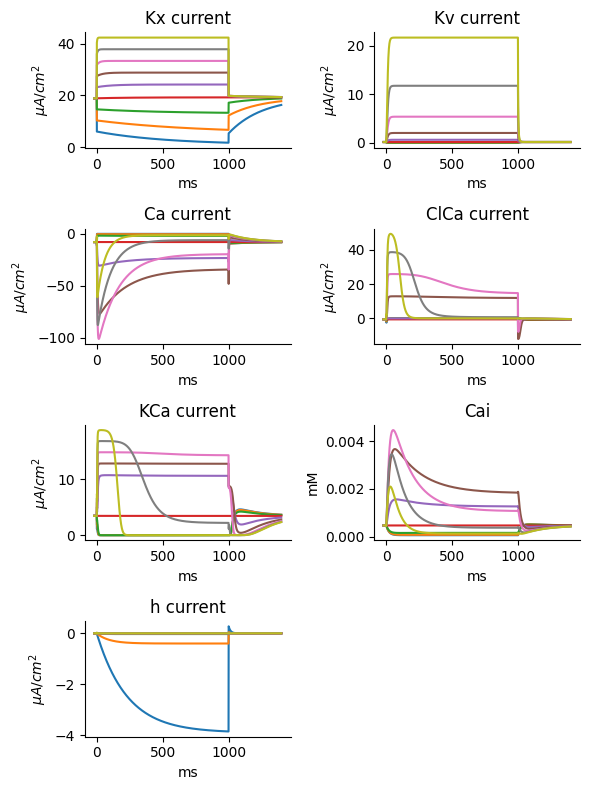

In [4]:
cell = Compartment()

cell.insert(Kx())
cell.insert(Kv())
cell.insert(Ca())
cell.insert(ClCa())
cell.insert(KCa())
cell.insert(CaPump())
# cell.insert(CaNernstReversal())
# The original code didn't allow eCa to be updated 
cell.insert(h())
cell.insert(Leak())

params = {
    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "ClCa_eClCa": -20,
    "ClCa_gClCa": 1.3e-3,
    "ClCa_Khalf": 1e-3, 

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.332e-3, # The photoreceptor will not oscillate
                        # if KCa_Khalf is lower than 0.33.
    "Ca_gCa": 4e-3,
    "eCa": 40,
    
    "Kv_gKv": 1e-3,
    "h_gh": 2.5e-3,
    "h_eh": -32,
    "Kx_gKx": 0.45e-3,
    "eK": -74,

    "length": 10/jnp.pi,
    "radius": 5,
    "capacitance": 30.0,
    "axial_resistivity": 34.5,
    "v": -34,
}

dt = 1 # ms    
V_hold = -30.0  # mV, the holding potential
T_hold = int(1000 / dt) # 300 ms
T_step = int(1000 / dt) # 300 ms


fig, ax = plt.subplots(4, 2, figsize=(6,8))
ax = ax.flatten()


# Calculate indices for -20 ms before step and 100 ms after step
pre_step_duration = 20  # ms
post_step_duration = 400  # ms

pre_step_indices = pre_step_duration // dt
post_step_indices = post_step_duration // dt

# Indices for the step period in the merged array
start_step_index = T_hold - pre_step_indices
end_step_index = T_hold + T_step + post_step_indices


# Create the time axis
time_window = jnp.arange(-pre_step_duration, T_step + post_step_duration, dt)

steady_state_currents_900 = []
steady_state_currents_1020 = []
V_steps = jnp.arange(-60, 21, 10)
for V_step in V_steps:
    currents, states = cell.voltage_clamp(V_hold1=V_hold, V_step=V_step, T_hold1=T_hold, T_step=T_step, dt=dt, init_params=params)
    ax = ax.flatten()
    for i, key in enumerate(currents):
        if key == "CaPump":
            ax[i].plot(time_window, states["CaPump"]["Cai"][start_step_index:end_step_index], label=f"V={V_step}")
            ax[i].set_title("Cai")
            ax[i].set_ylabel("mM")
        else:
            if key == "Leak":
                continue
            ax[i].plot(time_window, currents[key][start_step_index:end_step_index], label=f"V={V_step}")
            ax[i].set_title(key + " current")
            ax[i].set_ylabel(r"$μA/cm^2$")

        ax[i].set_xlabel("ms")
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)

ax[-1].axis('off')

fig.tight_layout()

## Photocurrent

For now and for the purpose of keeping consistent with the paper, we use the bright photocurrent generated from the NEURON code provided by the authors. In the future, we need to implement the outer segment model to generate the photocurrent (Kamiyama, et al., 1996).

Text(0, 0.5, '$nA$')

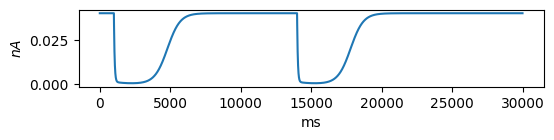

In [5]:
photocurrent = jnp.load("data/photocurrent.npy")
time_vec = jnp.arange(0, len(photocurrent), dt)
fig, ax = plt.subplots(1, 1, figsize=(6, 1))
ax.plot(time_vec, photocurrent)
ax.set_xlabel("ms")
ax.set_ylabel(r"$nA$")


Site note: In the paper, the photocurrent was described as a constant dark current (-0.04 nA) with the light waveform approximated by two exponential functions and one sigmoidal function, with amplitude of 0.04 nA, making it range from -0.04 nA to 0 nA. But in the code, what feeded into the model was a sign-flipped version of what they described and plotted in the paper. 

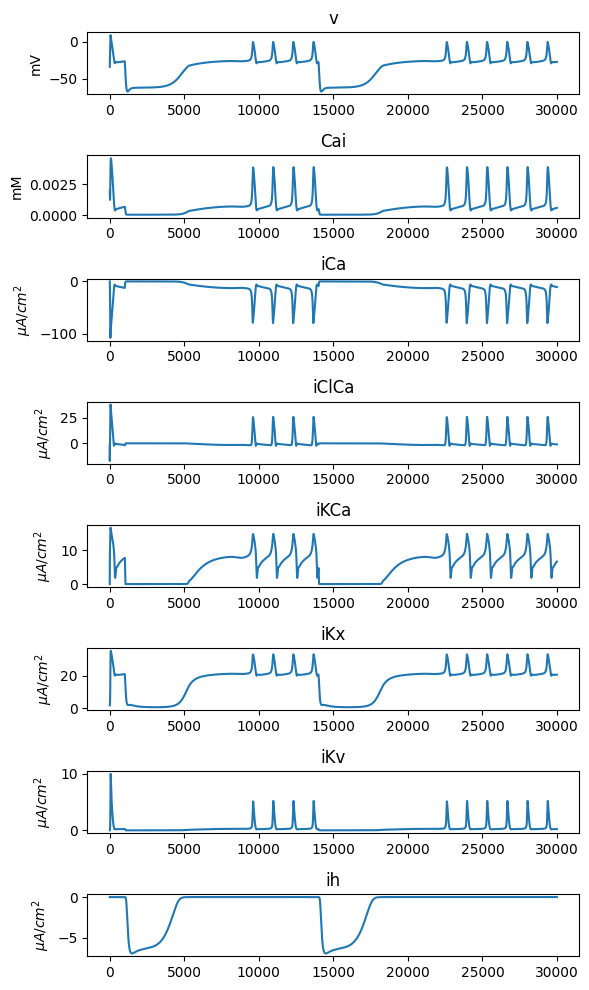

In [6]:
cell = Compartment()

cell.insert(h())
cell.insert(Kx())
cell.insert(Kv())
cell.insert(Ca())
cell.insert(ClCa())
cell.insert(KCa())
cell.insert(CaPump())
# cell.insert(CaNernstReversal())
cell.insert(Leak())

params = {
    "length": 10/jnp.pi,
    "radius": 5,
    "capacitance": 30.0,
    "axial_resistivity": 34.5,
    "v": -34,

    "Leak_gLeak": 0.52e-3,
    "Leak_eLeak": -74,

    "eK": -74,
    "Kv_gKv": 1e-3,
    "Kx_gKx": 0.45e-3,

    "CaPump_depth": 10,
    "CaPump_taur": 20, 
    "CaPump_cainf": 5e-5,    

    "ClCa_eClCa": -20,
    "ClCa_gClCa": 1.3e-3,
    "ClCa_Khalf": 1e-3, 

    "KCa_gKCa": 0.2e-3,
    "KCa_Khalf": 0.33e-3,

    "Ca_gCa": 4e-3,
    "eCa": 40,
    
    "h_gh": 2.5e-3,
    "h_eh": -32,
}

for name, param in params.items():
    cell.set(name, param)

to_records = ["v", "Cai", "iCa", "iClCa", "iKCa", "iKx", "iKv", "ih",]

cell.stimulate(photocurrent, verbose=False)
for rec in to_records:
    cell.record(rec, verbose=False)

s = jx.integrate(cell, delta_t=dt)

mosaic = [[rec] for rec in to_records]
fig, ax = plt.subplot_mosaic(mosaic, figsize=(6, 10))
for i, rec in enumerate(to_records):
    ax[rec].plot(time_vec, s[i].T[:-1])
    ax[rec].set_title(rec)

    if rec == "v":
        ax[rec].set_ylabel("mV")
    elif rec == "Cai":
        ax[rec].set_ylabel("mM")
    else:
        ax[rec].set_ylabel(r"$μA/cm^2$")

fig.tight_layout()


Under the "dark" current (0.04 nA), the photoreceptor exhibits constant action potentials and becomes hyperpolarized under light conditions (as 0.04 nA decreases to 0 nA).

In [7]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-05-27 16:27:59CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.0.1

matplotlib: 3.8.3
jaxley    : 0.0.0
jax       : 0.4.26

Watermark: 2.4.3

